In [42]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### The main idea is done an EDA in a Dataset with one month of energy consume data second to second

In [7]:
df = pd.read_csv('one_month_consume.csv')
df = df.sort_values('timestamp')
df = df.drop('Unnamed: 0', axis=1).reset_index(drop=True)
df.head()

,device_id,timestamp,active_energy,reactive_energy
0,34,2022-02-01 00:00:00,0.000054,0.000016
1,34,2022-02-01 00:00:01,0.000053,0.000016
2,34,2022-02-01 00:00:02,0.000053,0.000010
3,34,2022-02-01 00:00:03,0.000053,0.000011
4,34,2022-02-01 00:00:04,0.000054,0.000013


### Total consume

In [11]:
print("Total consume in:",round(df.active_energy.sum(),2),'kWh')

Total consume in: 223.28 kWh


In [8]:
df['timestamp'] = df['timestamp'].astype('datetime64[s]')

In [43]:
df_epd = df.groupby(df['timestamp'].dt.day).sum()

[Text(0.5, 1.0, 'Consume by day')]

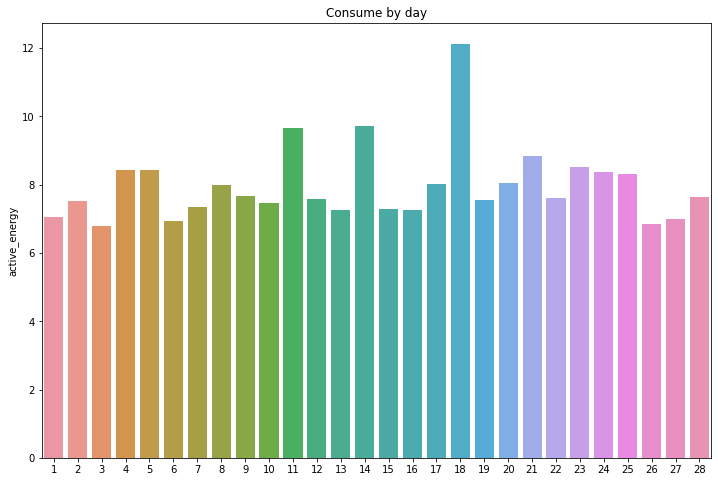

In [50]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_epd, x=np.arange(1, len(df_epd) + 1), y=df_epd.active_energy).set(title='Consume by day')

### Daily mean consume

In [13]:
print("Daily mean consume in this month:",round(df_epd.active_energy.mean(),2),'kWh/day')

Daily mean consume in this month: 7.97 kWh/day


### Day of greatest consumption

In [14]:
print("Day", df_epd.active_energy.idxmax(), "of this month was the day of greatest consumption, registering", round(df_epd.active_energy.max(),2), 'kWh of total energy, representing',round((df_epd.active_energy.idxmax() - df_epd.active_energy.max())/df_epd.active_energy.max()*100,2),'percent more than average')

Day 18 of this month was the day of greatest consumption, registering 12.13 kWh of total energy, representing 48.38 percent more than average


### Weekly analysis of the days

In [16]:
df['weekday'] = df['timestamp'].dt.day_name()
df = df.sort_values('timestamp').reset_index()
df = df.drop(['index'], axis=1)
df['week'] = [x.isocalendar()[1] for x in df['timestamp']]

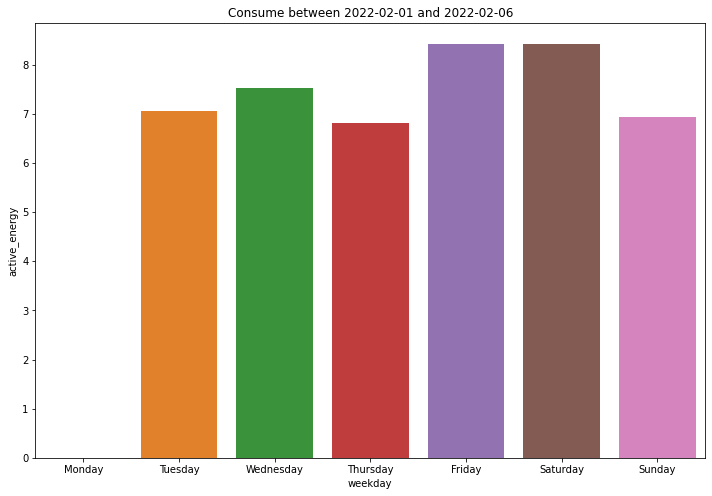

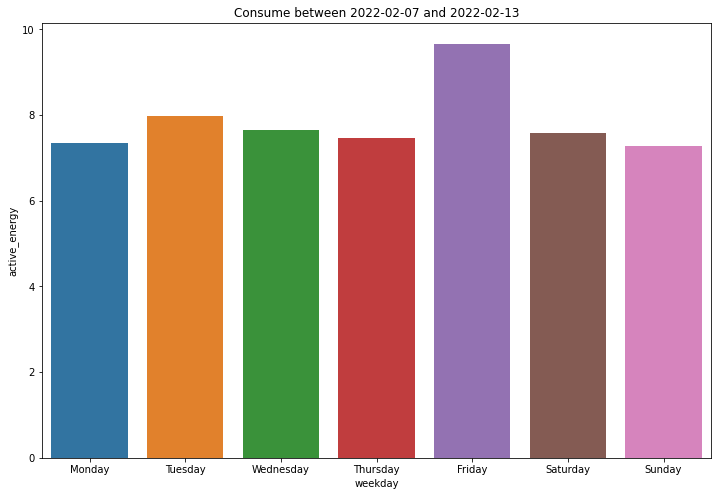

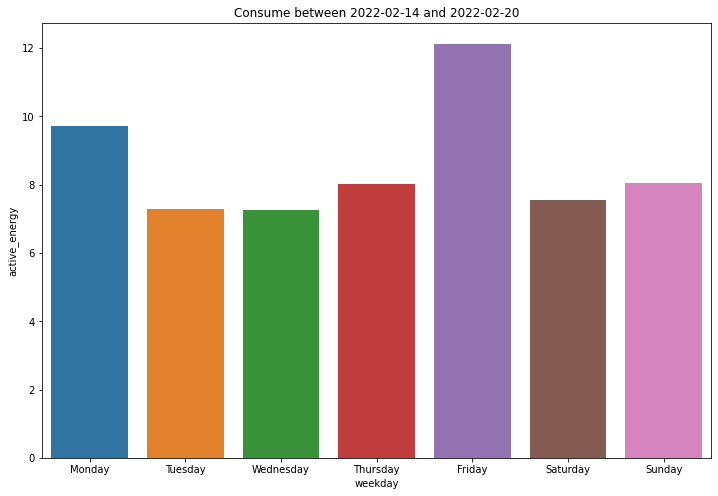

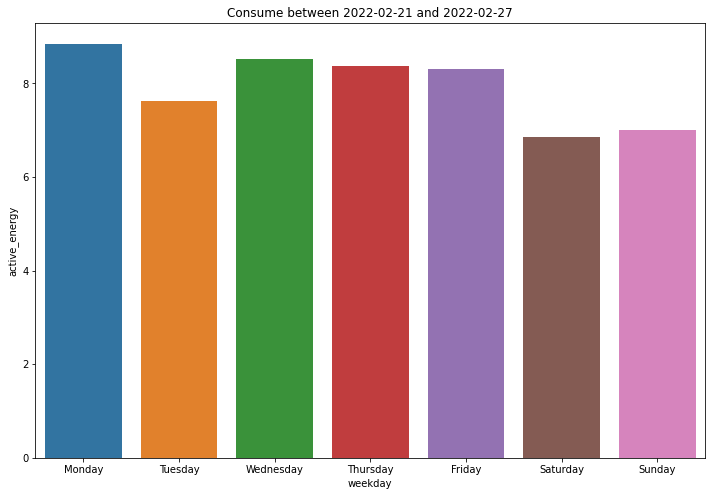

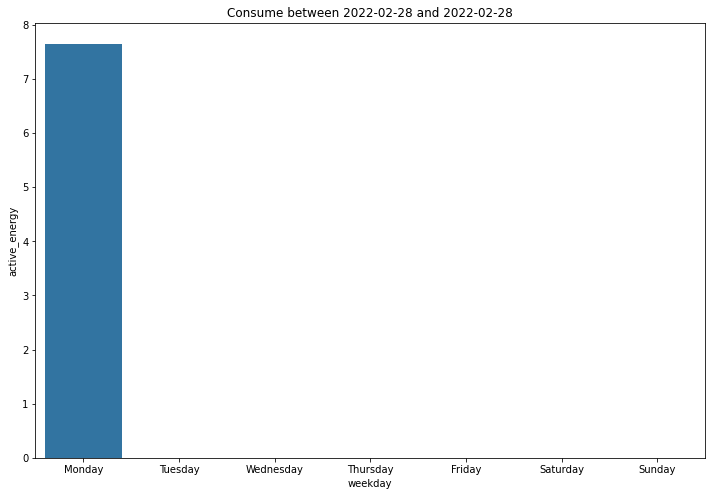

In [51]:
weeks = list(df['week'].unique())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in weeks:
    week_month = df[df['week'] == i]
    df_week_month = df[df['week'] == i].groupby('weekday').sum().reset_index()
    df_week_month['weekday'] = pd.Categorical(df_week_month['weekday'], categories=cats, ordered=True)
    df_week_month = df_week_month.sort_values('weekday')

    plt.figure(figsize=(12,8))
    title_text='Consume between ' + str(week_month['timestamp'].iloc[0].date()) +' and ' + str(week_month['timestamp'].iloc[-1].date())
    sns.barplot(data=df_week_month, x=df_week_month.weekday, y=df_week_month.active_energy).set(title=title_text)

### Total consume by week days

[Text(0.5, 1.0, 'Consume by week day')]

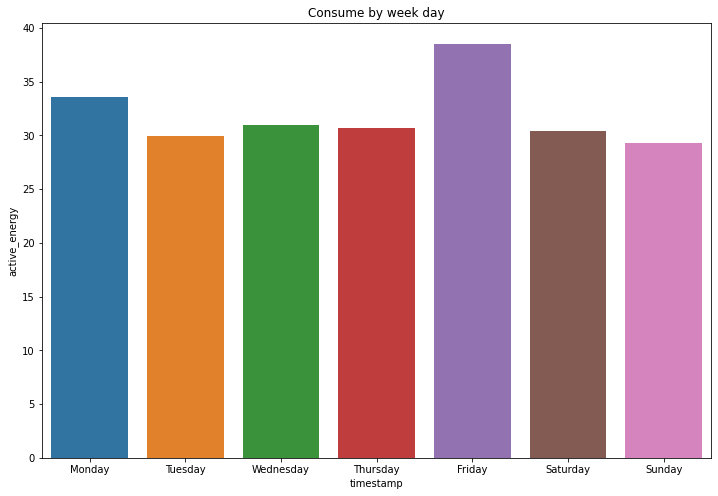

In [52]:
df_weekday = df.groupby(df['timestamp'].dt.day_name()).sum()
df_weekday['weekday'] = df_weekday.index
df_weekday['weekday'] = pd.Categorical(df_weekday['weekday'], categories=cats, ordered=True)
df_weekday = df_weekday.sort_values('weekday')

plt.figure(figsize=(12,8))
sns.barplot(data=df_weekday, x=df_weekday.index, y=df_weekday.active_energy).set(title='Consume by week day')

In [20]:
print("The day", df_weekday.active_energy.idxmax(), "was the day of the greatest consume , registering", round(df_weekday.active_energy.max(),2), 'kWh of energy consume,representing',round((df_weekday.active_energy.max() - df_weekday.active_energy.mean())/df_weekday.active_energy.mean()*100,2),'percent more than the average')

The day Friday was the day of the greatest consume , registering 38.53 kWh of energy consume,representing 20.79 percent more than the average


### Weekly and hour analysis

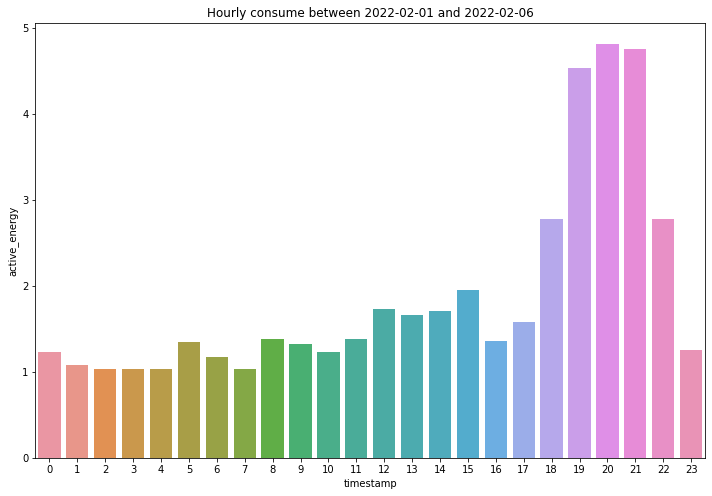

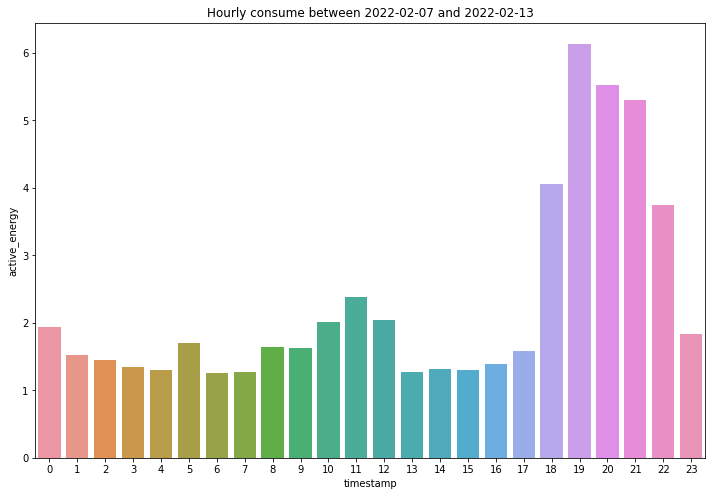

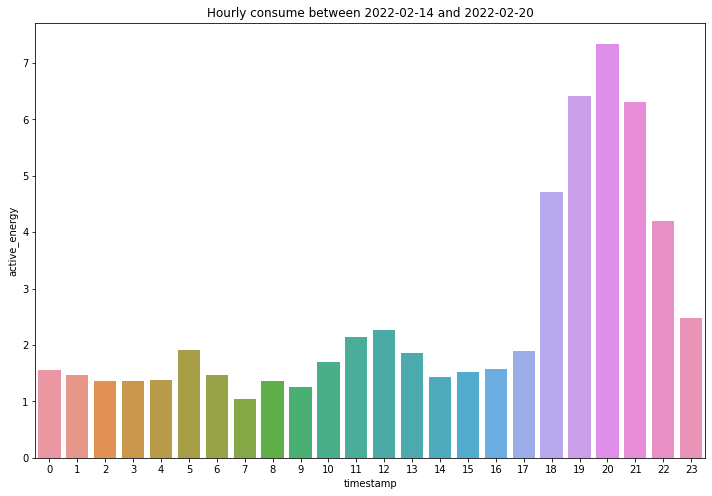

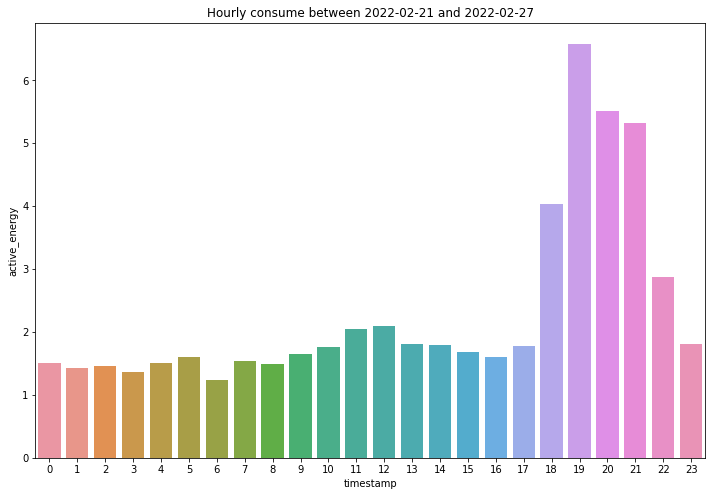

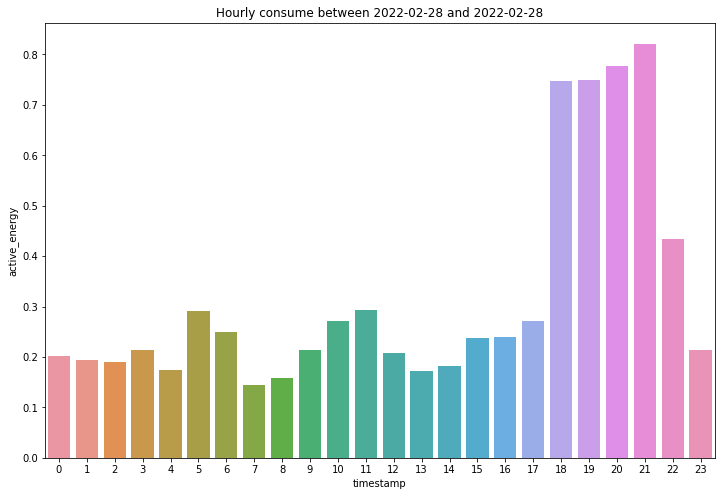

In [53]:
weeks = list(df['week'].unique())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in weeks:
    week_month = df[df['week'] == i]
    df_eph = week_month.groupby(week_month['timestamp'].dt.hour).sum()

    plt.figure(figsize=(12,8))
    title_text='Hourly consume between ' + str(week_month['timestamp'].iloc[0].date()) +' and ' + str(week_month['timestamp'].iloc[-1].date())
    sns.barplot(data=df_eph, x=df_eph.index, y=df_eph.active_energy).set(title=title_text)

### Total consume by hour

[Text(0.5, 1.0, 'Consume by hour')]

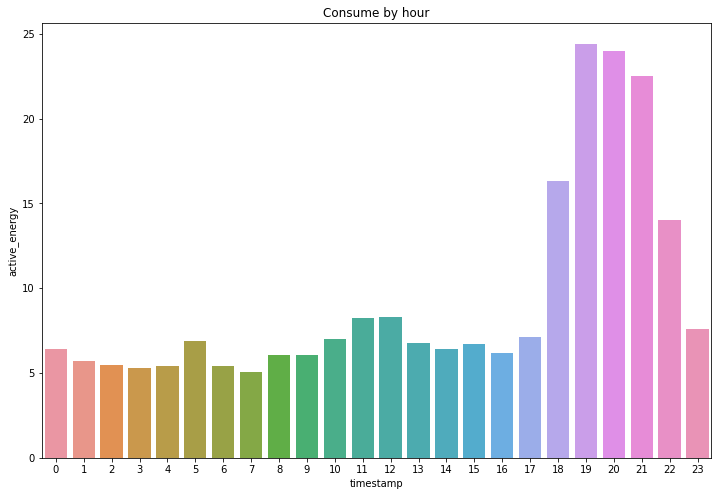

In [54]:
df_eph = df.groupby(df['timestamp'].dt.hour).sum()

plt.figure(figsize=(12,8))
sns.barplot(data=df_eph, x=df_eph.index, y=df_eph.active_energy).set(title='Consume by hour')

In [23]:
print("The", df_eph.active_energy.idxmax(), "was the time of greatest consumption, registering", round(df_eph.active_energy.max(),2), 'kWh of total energy, representing',round((df_eph.active_energy.max() - df_eph.active_energy.mean())/df_eph.active_energy.mean()*100,2),'percent more than average')

The 19 was the time of greatest consumption, registering 24.42 kWh of total energy, representing 162.49 percent more than average


### Atypical values

In [24]:
# To get the atypical values, we do the analysis each hour and each day
df_epd_eph = df.groupby([df['timestamp'].dt.day, df['timestamp'].dt.hour]).sum()
df_epd_eph['local_idx'] = np.arange(1, len(df_epd_eph) + 1)

idx_atypical = np.array([])
atypical = np.array([])

idx = pd.IndexSlice
for i in range(24):
    df_esahour = df_epd_eph.loc[idx[:, i], :]

    z_scores = (df_esahour.active_energy - df_esahour.active_energy.mean())/df_esahour.active_energy.std()
    df_esahour = df_esahour[z_scores > 3]

    idx_atypical = np.concatenate([idx_atypical, df_esahour.local_idx.values])
    atypical = np.concatenate([atypical, df_esahour.active_energy.values])

In [30]:
print("Describing the outliers")
hours_day = df.groupby(df['timestamp'].dt.hour).mean()
df_epd_eph_mean = df.groupby([df['timestamp'].dt.day, df['timestamp'].dt.hour]).mean()
df_epd_eph_mean['local_idx'] = np.arange(1, len(df_epd_eph) + 1)
for i in list(idx_atypical):
    value = df_epd_eph_mean[df_epd_eph_mean['local_idx'] == i]
    day = value.index[0][0]
    hour = value.index[0][1]
    atipic_value = value['active_energy'].iloc[0]
    mean_hour = hours_day['active_energy'].iloc[hour]
    difference = (atipic_value / mean_hour)
    print("An outlier was detected on the day", day , 'at' , hour ,'hours, surpassing in a', round(difference,2) , 'times of the average of that hour of the month')

Describing the outliers
An outlier was detected on the day 13 at 0 hours, surpassing in a 2.97 times of the average of that hour of the month
An outlier was detected on the day 13 at 1 hours, surpassing in a 2.07 times of the average of that hour of the month
An outlier was detected on the day 13 at 2 hours, surpassing in a 1.79 times of the average of that hour of the month
An outlier was detected on the day 25 at 4 hours, surpassing in a 1.7 times of the average of that hour of the month
An outlier was detected on the day 13 at 8 hours, surpassing in a 2.1 times of the average of that hour of the month
An outlier was detected on the day 11 at 10 hours, surpassing in a 3.61 times of the average of that hour of the month
An outlier was detected on the day 11 at 11 hours, surpassing in a 3.53 times of the average of that hour of the month
An outlier was detected on the day 24 at 14 hours, surpassing in a 2.62 times of the average of that hour of the month
An outlier was detected on the 

### Total ghost consume

In [31]:
i = 1
consume_month = df.copy()
while consume_month.active_energy.max() - consume_month.active_energy.min() > 5e-5:
    consume_month.active_energy[consume_month.active_energy > consume_month.active_energy.mean()] = consume_month.active_energy.mean()
    i += 1

C:\Users\JesusSanchez\AppData\Local\Temp\ipykernel_15924\2699722808.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
print('The phantom consumption for the entire month was around',consume_month.active_energy.sum(),'kWh, which represented about a',round((consume_month.active_energy.sum()/df['active_energy'].sum())*100,2), 'percentage of your total consumption during the entire month')

The phantom consumption for the entire month was around 107.16257221638891 kWh, which represented about a 48.0 percentage of your total consumption during the entire month


### Ghost consume by day

In [57]:
df['day'] = df['timestamp'].dt.day
always_on_days = []
for i in df['day'].unique():
    df_day = df[df['day'] == i][['active_energy']]
    i = 1
    while df_day['active_energy'].max() - df_day['active_energy'].min() > 5e-5:
        df_day['active_energy'][df_day['active_energy']>df_day['active_energy'].mean()] = df_day['active_energy'].mean()
        i += 1
    always_on_days.append(df_day['active_energy'].mean())
always_on_days = pd.DataFrame(data=always_on_days, columns=['active_energy'])

In [35]:
print("The day", always_on_days.active_energy.idxmax()+1, "it was the day of greatest phantom consumption, registering", round(always_on_days.active_energy.max()*86400,2), 'kWh of ghost energy consume, what a represents',round((always_on_days.active_energy.max() - always_on_days.active_energy.mean())/always_on_days.active_energy.mean()*100,2),'percent more than the average of the other days of the month')

The day 23 it was the day of greatest phantom consumption, registering 5.68 kWh of ghost energy consume, what a represents 22.71 percent more than the average of the other days of the month


[Text(0.5, 1.0, 'Daily ghost consume')]

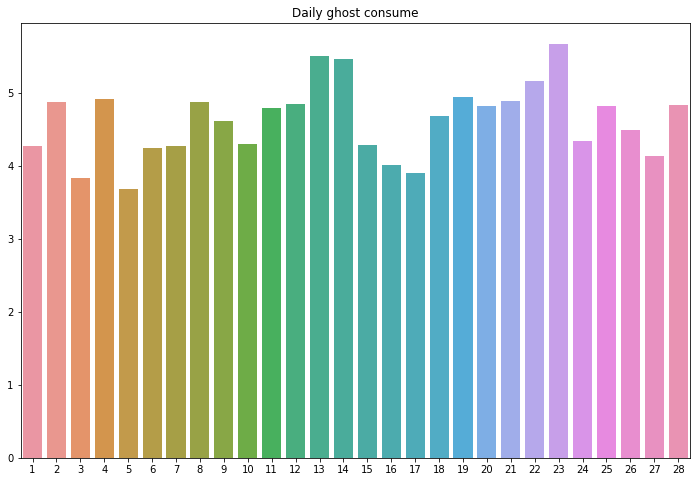

In [58]:
always_on_days.active_energy = always_on_days.active_energy * 86400

plt.figure(figsize=(12,8))
sns.barplot(data=always_on_days, x=always_on_days.active_energy.index+1, y=always_on_days.active_energy.values).set(title='Daily ghost consume')

### Ghost consume by week

In [59]:
always_on_week = []
for i in df['week'].unique():
    df_week = df[df['week'] == i][['active_energy']]
    i = 1
    while df_week['active_energy'].max() - df_week['active_energy'].min() > 5e-5:
        df_week['active_energy'][df_week['active_energy']>df_week['active_energy'].mean()] = df_week['active_energy'].mean()
        i += 1
    always_on_week.append(df_week['active_energy'].mean())
always_on_week = pd.DataFrame(data=always_on_week, columns=['active_energy'])

In [40]:
print("The week", always_on_week.active_energy.idxmax()+1, "of the month was the one with the highest phantom consumption, registering", round(always_on_week.active_energy.max()*604800,2), 'kWh of total energy consumed by concept of phantom energy, which represents a',round((always_on_week.active_energy.max() - always_on_week.active_energy.mean())/always_on_week.active_energy.mean()*100,2),'percentage more than the average of the other weeks of the month')

The week 5 of the month was the one with the highest phantom consumption, registering 20480820.35 kWh of total energy consumed by concept of phantom energy, which represents a 13.2 percentage more than the average of the other weeks of the month


[Text(0.5, 1.0, 'Weekly ghost consume')]

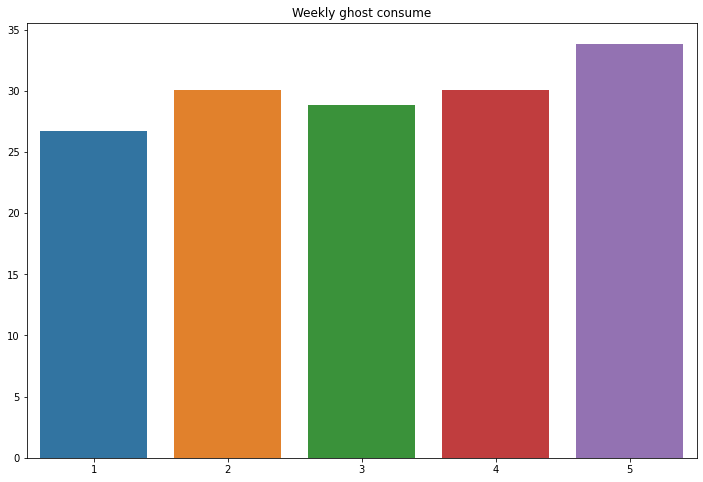

In [60]:
always_on_week.active_energy = always_on_week.active_energy * 604800

plt.figure(figsize=(12,8))
sns.barplot(data=always_on_week, x=always_on_week.active_energy.index+1, y=always_on_week.active_energy.values).set(title='Weekly ghost consume')